Library Imports

Goal: Create a data pipeline for studying the subtitles of TV shows.

In [4]:
suppressPackageStartupMessages(library(srt))
suppressPackageStartupMessages(library(tm))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(textstem))
suppressPackageStartupMessages(library(tidytext))
suppressPackageStartupMessages(library(zoo))
suppressPackageStartupMessages(library(dplyr))

Get the names of our files for reading.

In [5]:
filenames <- list.files(path="./GilmoreGirls",pattern="*.srt")
# head(filenames)

Create Meta-table to aggregate data from all the episodes 

In [6]:
meta <- data.frame(
    episodeName=character(),
    fullSubtitles=character(),
    subtitleCount=numeric(),
    wordCount=numeric(),
    runTime=numeric(),
    speakingTime=numeric(),

    averageWPM=numeric(),
    stdWPM=numeric(),

    averageSubtitleLength=numeric(),
    stdSubtitleLength=numeric(),

    averageSubtitleWPM = numeric(),
    stdSubtitleWPM = numeric(),

    averageduration = numeric(),
    stdDuration = numeric(),

    stringsAsFactors = FALSE
)

Now the main function to create a file for each episode, as well as adding rows to our meta table

In [7]:
readFileByIndex <- function(i){

    # some variables parsed from filenames
    episodeCode <- str_extract(filenames[i],"[0-9]+.*?[0-9]+")
    title <- str_extract(filenames[i],"(?<=[0-9]\\s-\\s).*(?=\\.en)")
    season <- str_extract(filenames[i],"(?<=(\\s-\\s)).*?(?=x)")
    episode <- str_extract(filenames[i],"(?<=([0-9]x)).*?(?=\\s)")
    prefix <- paste(getwd(),"/GilmoreGirls/",sep="")
     

    df <- read_srt(paste(prefix,filenames[i],sep=""))
    df <- df[-nrow(df),] #drop last row because it's credit information

    # some functions to clean up
    dropPunct <- (function (x) gsub('[[:punct:]]+','',x))
    dropNL <- (function(x) gsub("\n", " ", x))

    # create new csv for
    df <- df %>% 
        mutate(subtitle = sapply(subtitle,tolower)) %>%

        # cleanWords will clean up punctuation 
        mutate(cleanWords = sapply(subtitle,dropNL)) %>%
        mutate(cleanWords = sapply(cleanWords,removePunctuation)) %>%

        mutate(wordCount = sapply(strsplit(cleanWords,"\\s+"),length)) %>%
        mutate(cumWordCount = cumsum(wordCount)) %>%

        # deepCleanWords, for advanced processing
        # mutate(deepCleanWords = sapply(cleanWords,removeWords,stopwords('english'))) %>%
        # mutate(deepCleanWords = sapply(deepCleanWords, textstem::lemmatize_strings))
        
        mutate(minute = (1+floor(end / 60))) %>%
        mutate(duration = end-start) %>%
        mutate(subtitleWPM = wordCount/duration) %>% # All words / total time
        mutate(cumTimeSpeaking = cumsum(duration)) %>%
        mutate(rollingWPM = rollmean(cumWordCount/end,k=5,fill=0)) 
        # mutate(rollingWPMSpeaking = rollmean(cumWordCount/cumTimeSpeaking,k=10,fill=0)) # All words / time talking

    # assemble row for Meta table
    temp <- data.frame(
        episodeName     = paste(episodeCode,' - ',title,collapse = ""),
        subtitleCount   = nrow(df),
        fullSubtitles   = paste(df$subtitle,collapse = ' '),
        totalWordCount   = sum(sapply(strsplit(paste(df$subtitle),"\\s+"), length)),
        runTime         = df$end[length(df$end)],
        speakingTime    = df$cumTimeSpeaking[length(df$cumTimeSpeaking)],

        averageWPM      = mean(df$rollingWPM, na.rm = TRUE),
        stdWPM          = sd(df$rollingWPM, na.rm = TRUE),

        averageSubtitleLength = mean(df$wordCount, na.rm = TRUE),
        stdSubtitleLength = sd(df$wordCount, na.rm = TRUE),

        averageSubtitleWPM = mean(df$subtitleWPM, na.rm = TRUE),
        stdSubtitleWPM  = sd(df$subtitleWPM, na.rm = TRUE),

        averageDuration = mean(df$duration, na.rm = TRUE),
        stdDuration     = mean(df$duration, na.rm = TRUE)
    )

    write.csv(df,paste('episode_analysis/',episodeCode,' - ',title,collapse=""))

    meta <<- rbind(meta,temp)


    return(df)
}

Check data, and save a copy to double check it in a csv reader.

In [8]:
for (i in 1:length(filenames)){
    testdf <- readFileByIndex(i)
    # if (i %% 10){
    #     print(tail(testdf,1))
    # }
}

metaSkipSubs <- meta[,!(names(meta) %in% "fullSubtitles")]
head(metaSkipSubs)

write.csv(meta,paste('meta.csv',collapse=""))



,episodeName,subtitleCount,totalWordCount,runTime,speakingTime,averageWPM,stdWPM,averageSubtitleLength,stdSubtitleLength,averageSubtitleWPM,stdSubtitleWPM,averageDuration,stdDuration
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1x01 - Pilot,683,5443,2597.533,1722.050,1.835775,0.3222240,7.734993,3.549200,2.980968,0.9143331,2.521303,2.521303
2,1x02 - The Lorelais' First Day at Chilton,754,5930,2535.550,1789.262,2.015317,0.3555460,7.648541,3.625911,3.112435,0.9657955,2.373027,2.373027
3,1x03 - Kill Me Now,757,6453,2579.825,1906.310,2.526197,0.3240043,8.224571,3.443770,3.219969,0.9218293,2.518243,2.518243
4,1x04 - The Deer Hunters,785,6446,2623.680,1932.160,2.264309,0.3357959,7.950318,3.438428,3.182449,0.9301802,2.461350,2.461350
5,1x05 - Cinnamon's Wake,711,5803,2531.652,1764.392,2.165844,0.3500775,7.890295,3.579174,3.101427,0.9422581,2.481564,2.481564
6,1x06 - Rory's Birthday Parties,751,6335,2605.976,1882.171,2.449102,0.2969974,8.166445,3.473748,3.208177,0.9100049,2.506220,2.506220


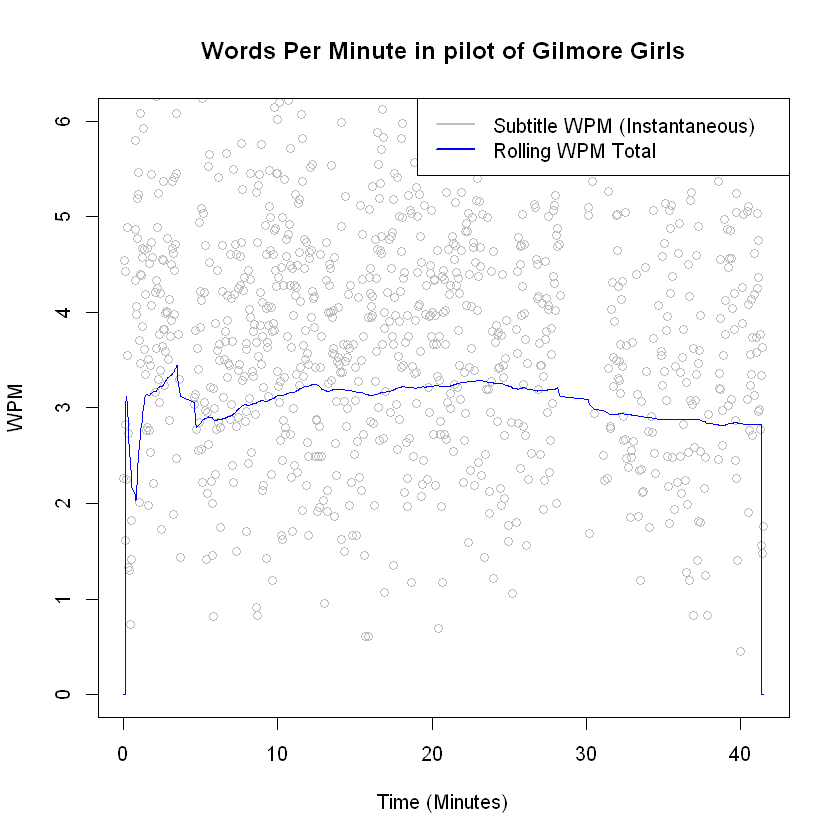

In [9]:
# paste(testdf$cleanWords,collapse = " ")

plot(testdf$start/60,testdf$subtitleWPM, xlab="Time (Minutes)",ylab="WPM", main='Words Per Minute in pilot of Gilmore Girls',
 col='gray',ylim=c(0,6))

       lines(testdf$start/60,testdf$rollingWPM,col="blue")
       # lines(testdf$start/60,testdf$rollingWPMSpeaking,col="red")
       legend("topright", legend = c("Subtitle WPM (Instantaneous)", "Rolling WPM Total"),
              col = c("gray", "blue"), lwd = 2)

In [10]:
# plot(meta$,testdf$subtitleWPM, xlab="Time (Minutes)",ylab="WPM", main='Words Per Minute in pilot of Gilmore Girls',
#  col='gray',ylim=c(0,6))

#        lines(testdf$start/60,testdf$rollingWPM,col="blue")
#        # lines(testdf$start/60,testdf$rollingWPMSpeaking,col="red")
#        legend("topright", legend = c("Subtitle WPM (Instantaneous)", "Rolling WPM Total"),
#               col = c("gray", "blue"), lwd = 2)